In [14]:
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
from torchvision.transforms import v2
from huggingface_hub import notebook_login
from huggingface_hub import HfApi

# For displaying:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
torch.__version__, transformers.__version__

('2.1.1', '4.40.2')

In [16]:
mbatch_size = 2

In [17]:
# Device:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [18]:
# Load model:
tokenizer = transformers.AutoTokenizer.from_pretrained('aehrc/cxrmate-rrg24')
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-rrg24', trust_remote_code=True).to(device=device)
model.eval()

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Resize(size=model.config.encoder.image_size, antialias=True),
        v2.CenterCrop(size=[model.config.encoder.image_size]*2),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=model.config.encoder.image_mean, std=model.config.encoder.image_std),
    ]
)
        

/apps/python/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# HF token for accessing the dataset:
api = HfApi()
user_info = api.whoami()
if not user_info:
    notebook_login()

In [20]:
# Data:
dataset = datasets.load_dataset('StanfordAIMI/interpret-cxr-test-public', token=True)['test']

def transform_batch(batch):
    batch['images'] = [torch.stack([transforms(j) for j in i]) for i in batch['images']]
    batch['images'] = torch.nn.utils.rnn.pad_sequence(batch['images'], batch_first=True, padding_value=0.0)  
    return batch

dataset = dataset.with_transform(transform_batch)
dataloader = DataLoader(dataset, batch_size=mbatch_size, shuffle=True)
batch = next(iter(dataloader))

'Study 1:'

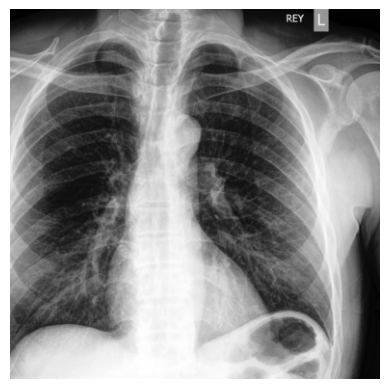

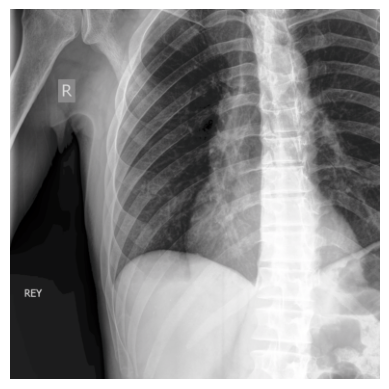

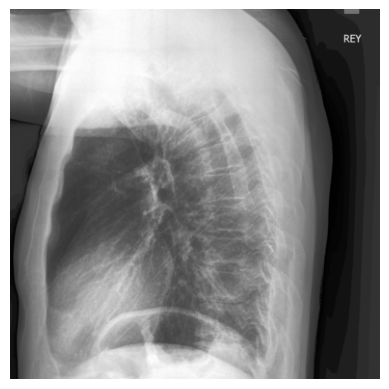

'Study 2:'

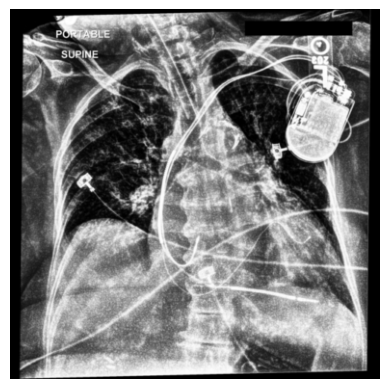

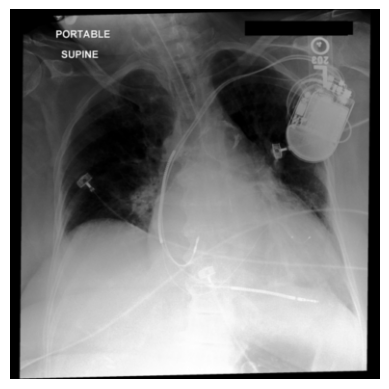

In [21]:
# Display images:
for i, j in enumerate(batch['images']):
    display(f'Study {i+1}:')
    for k in j:
        if not torch.all(k == 0):
            image = k.numpy()
            for channel in range(image.shape[0]):
                image[channel] -= image[channel].min()
                image[channel] /= image[channel].max()
            image = (image * 255).astype(np.uint8)
            plt.imshow(image.transpose(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.show()

In [22]:
# Generate findings only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')]],
    eos_token_id=tokenizer.sep_token_id
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\n') for i in findings]

Findings:
	A comparative study is conducted with a previous x-ray from the date. no significant radiological changes are observed compared to the previous study. no foci of pulmonary consolidation are observed. no pleural effusion. right pneumothorax. no alterations in the cardiomedastinal silhouette and pulmonary hila. bilateral rib fracture calluses.

Findings:
	 portable chest. endotracheal tube 2 cm from the carina. enlargement of the cardiac silhouette, cardiomegaly, and bilateral pulmonary opacities predominantly in the upper and middle fields. no signs of pleural effusion. pacemaker carrier.



In [23]:
# Generate impression only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NI]')]],
    input_ids=torch.tensor([[tokenizer.bos_token_id, tokenizer.convert_tokens_to_ids('[NF]'), tokenizer.sep_token_id]]*mbatch_size, device=device, dtype=torch.long),
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Impression:\n\t{i}\n') for i in impression]

Impression:
	1. SINGLE FRONTAL RADIOGRAPH OF THE CHEST DEMONSTRATES A SMALL LEFT PNEUMOTHORAX. 2. LUNGS DEMONSTRATE RETICULAR OPACITIES, LIKELY REFLECTING UNDERLYING EMPHYSEMA. NO PLEURAL EFFUSIONS. 3. VISUALIZED OSSEOUS STRUCTURES AND SOFT TISSUES DEMONSTRATE EXTENSIVE SUBCUTANEOUS EMPHYSEMA ALONG THE LEFT NECK AND LEFT CHEST WALL.

Impression:
	 from cardiac silhouette. Pulmonary vascular congestion has improved since ___. There is no pulmonary edema. There is no appreciable pleural effusion and no indication of pneumothorax. ET tube is in standard placement. Transvenous right atrial and left ventricular pacer leads are unchanged in their respective positions. The new left trans subclavian right atrial biventricular pacer defibrillator leads are unchanged in their respective positions. There is no mediastinal widening, pneumothorax, or pleural effusion.



In [24]:
# Generate both sections:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')], [tokenizer.convert_tokens_to_ids('[NI]')]],
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\nImpression:\n\t{j}\n') for i,j in zip(findings, impression)]

Findings:
	Chest x-ray, subcutaneous emphysema in the left hemithorax, pneumomediastinum. no pneumothorax observed. right subcutaneous emphysema. cardiomedastinal silhouette and pulmonary hila of normal size and morphology. no other alterations of pathological significance. no radiological signs of pleural effusion. no alterations in lung parenchyma. no other significant findings in the lung parenchyma or in the cardiomedastinal silhouette. left rib fracture calluses. cardiomedastinal silhouette and pulmonary hila of normal size and morphology. no alterations in the bony structures of the thoracic cage. no other alterations in the bone structures included in the study. bilateral rib fractures without apparent pleural effusion. no pleural effusion. no other alterations. post-surgical changes in the left hemithorax. study in the right hemithorax partially visualized due to multiple rib fractures. no pneumothorax identified. pulmonary parenchyma without significant changes compared to the